<a href="https://colab.research.google.com/github/GiuliaFContardi/FL_IDS-GAN/blob/main/VanillaGAN_3_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load in data**

In [ ]:
# link & mount to google drive to import data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
# import pre-processed data from google drive and store in dataframe using pandas function
# split the dataset into 6 different datasets, one for each class
# GAN model will generate samples for one class at a time, therefore dataframe needs to be split by class. Will be joined again after all samples have been generated.

#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Botnet35.csv')
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_BruteForce35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DDoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_DoS35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Portscan35.csv')
#df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/improved/Pre-processed_versions/terzoPreprocessing/Single_attack/d_Benign35.csv')

In [ ]:
#ho salvato il file con 36 feature... la tolgo qui...
df = df.iloc[:, :-1]

In [ ]:
data_columns = df.columns

In [ ]:
pd.options.display.float_format = '{:,.20f}'.format

## **Define model architecture**

## Import

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# Allow matplotlib images to render immediately.
%matplotlib inline

import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential

In [ ]:
!pip install sdv
%pip install sdmetrics
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.2/143.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.8/169.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of sdmetrics to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.7/170.7 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Parametri



1.   Alpha (for LeakyReLU):
> * alpha is the slope of the negative part of the LeakyReLU activation function. It helps introduce a small, non-zero slope to the activation function for negative input values, preventing the neuron from being completely inactive.
> * A common value for alpha is in the range of 0.01 to 0.3. You can experiment with different values to see what works best for your specific dataset and model.

2.   Momentum (for Batch Normalization):
> * momentum is a parameter used in the update of the moving averages in batch normalization. It controls the contribution of the previous running mean and variance to the new estimates.
> * Common values for momentum are between 0.9 and 0.999. Higher values give more weight to the new batch, and lower values give more weight to the history.

3.   Dropout Rate (for Discriminator):
> * rate is the dropout rate, which represents the fraction of input units to drop during training.
> * A common value for rate is between 0.3 and 0.5. This means dropping 30% to 50% of the input units during training.





In [ ]:
alpha_leakyRelu = 0.01 #@param
momentumBN = 0.8 #@param
dropoutRate = 0.1 #@param
neuroni = 128 #@param

In [ ]:
#generator & discriminator parameters

batch_size = 2048 #@param
lr_d=0.0001 #@param
lr_g=0.0003 #@param

beta=0.5
noise_dim = 16  #@param

#--------------------------------
data_dim=35 #numeroFeatures
#-------------------------------

#training parameters
epochs = 6000 #@param
n_eval = 50 #@param

In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/progettoTesi/grafici_pdf/vanillaGan/setHBase'

### Plot GAN

FONTE: https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/




In [ ]:
def plot_historyBIG(d_hist, g_hist, a1_hist, a2_hist):
    # create a larger figure
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    # plot loss
    axs[0].plot(d_hist, label='d-loss')
    axs[0].plot(g_hist, label='g-loss')
    axs[0].legend()

    # plot discriminator accuracy
    axs[1].plot(a1_hist, label='acc-real')
    axs[1].plot(a2_hist, label='acc-fake')
    axs[1].legend()

    #salva in Drive
    plt.savefig(f"{images_dir}/VanillaGan_curveApprendim_setHBase_Bruteforce.pdf", dpi=200, format='pdf')

    plt.show()

## **Architettura Modello**
* Fonte codice base: https://github.com/CameronSwart/GAN-IDS

#### Vanilla GAN

In [ ]:
def gan_system():

    def build_generator(data_dim, noise_dim):
        model = Sequential(name="Generatore")
        model.add(Dense(neuroni, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform", input_dim=noise_dim))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(neuroni*2, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(neuroni*4, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(BatchNormalization(momentum=momentumBN))
        model.add(Dense(data_dim, activation="sigmoid")) # Use sigmoid activation in the output layer to constrain values to [0, 1]
        return model

    generator = build_generator(data_dim, noise_dim)

    optimizerD = tf.keras.optimizers.Adam(learning_rate=lr_d)

    def build_discriminator(data_dim):
        model = Sequential(name="Discriminatore")
        model.add(Dense(neuroni*4, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform", input_dim=data_dim))
        model.add(Dropout(dropoutRate))
        model.add(Dense(neuroni*2, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate))
        model.add(Dense(neuroni, activation=LeakyReLU(alpha_leakyRelu), kernel_initializer="he_uniform"))
        model.add(Dropout(dropoutRate)) #prima non c'era!!!
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return model

    discriminator = build_discriminator(data_dim)

    optimizerGAN = tf.keras.optimizers.Adam(learning_rate=lr_g)

    def build_gan(generator, discriminator):
        # make weights in the discriminator not trainable
        discriminator.trainable = False
        # connect generator and dicriminator
        model = Sequential(name="GAN")
        model.add(generator)
        model.add(discriminator)
        model.compile(loss = "binary_crossentropy", optimizer = optimizerGAN)
        return model


    gan = build_gan(generator, discriminator)

    return gan, generator, discriminator



def train(gan, generator, discriminator, data, noise_dim, n_epochs, n_batch, n_eval):
    #Half batch size for updateting discriminator
    half_batch = int(n_batch / 2)

    d_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list()

    #generate class labels for fake = 0 and real = 1
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    y_gan = np.ones((n_batch, 1))

    np.random.seed(3) # used for retestability

    #training loop
    for j in range(n_epochs):
        #select random batch from the real numerical data
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_data = data[idx]

        #Generate noise from a Gaussian (normal) distribution
        noise = np.random.normal(0, 1, (half_batch, noise_dim))
        fake_data = generator.predict(noise)

        #train the discriminator and return losses
        d_loss_real, d_acc1 = discriminator.train_on_batch(real_data, valid)
        d_loss_fake, d_acc2 = discriminator.train_on_batch(fake_data, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        #generate noise for generator input and  train the generator (to have the discriminator label samples as valid)
        noise = np.random.normal(0, 1, (n_batch, noise_dim))
        g_loss = gan.train_on_batch(noise, y_gan)

        d_hist.append(d_loss)
        g_hist.append(g_loss)
        a1_hist.append(d_acc1)
        a2_hist.append(d_acc2)

        #evaluate progress
        if (j+1) % n_eval == 0:
            print('==>> Epoch %d ==> dRealLoss=%.3f, dFakeLoss=%.3f, dTOTLoss=%.3f, gLoss=%.3f, accR=%d, accF=%d' % (j, d_loss_real, d_loss_fake,d_loss, g_loss, int(100*d_acc1), int(100*d_acc2)))

    #plot losses after training
    plot_historyBIG(d_hist, g_hist, a1_hist, a2_hist)


In [ ]:
gan, generator, discriminator = gan_system()

#### Summary Architettura

In [ ]:
gan.summary()

Model: "GAN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Generatore (Sequential)     (None, 35)                188323    
                                                                 
 Discriminatore (Sequential  (None, 1)                 182785    
 )                                                               
                                                                 
Total params: 371108 (1.42 MB)
Trainable params: 186531 (728.64 KB)
Non-trainable params: 184577 (721.00 KB)
_________________________________________________________________


In [ ]:
generator.summary()

Model: "Generatore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2176      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2

In [ ]:
discriminator.summary()

Model: "Discriminatore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               18432     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 1)              

## **Training & Generazione**

In [ ]:
#preparo il dataframe in np array
real_data = df.to_numpy()

Output streaming troncato alle ultime 5000 righe.
32/32 [==============================] - 0s 1ms/step
==>> Epoch 1099 ==> dRealLoss=0.659, dFakeLoss=0.653, dTOTLoss=0.656, gLoss=0.808, accR=61, accF=60
32/32 [==============================] - 0s 2ms/step
==>> Epoch 1149 ==> dRealLoss=0.672, dFakeLoss=0.647, dTOTLoss=0.659, gLoss=0.803, accR=62, accF=63
32/32 [==============================] - 0s 1ms/step
==>> Epoch 1199 ==> dRealLoss=0.668, dFakeLoss=0.649, dTOTLoss=0.659, gLoss=0.805, accR=61, accF=61
32/32 [==============================] - 0s 1ms/step
==>> Epoch 1249 ==> dRealLoss=0.671, dFakeLoss=0.648, dTOTLoss=0.660, gLoss=0.798, accR=58, accF=62
32/32 [==============================] - 0s 1ms/step
==>> Epoch 1299 ==> dRealLoss=0.658, dFakeLoss=0.648, dTOTLoss=0.653, gLoss=0.797, accR=60, accF=61
32/32 [==============================] - 0s 2ms/step
==>> Epoch 1349 ==> dRealLoss=0.668, dFakeLoss=0.645, dTOTLoss=0.656, gLoss=0.799, accR=59, accF=62
32/32 [=========================

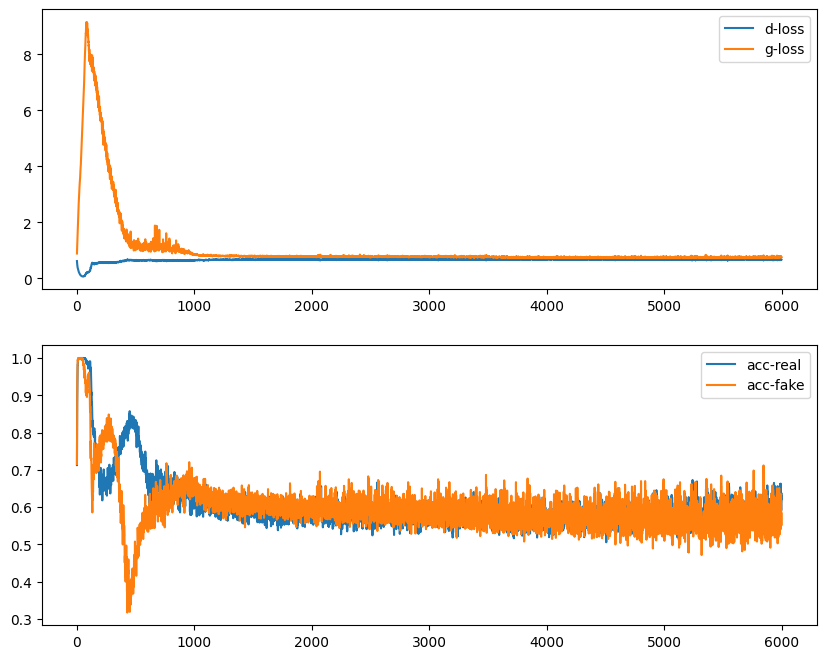

In [ ]:
train(gan, generator, discriminator, real_data, noise_dim,
      epochs, batch_size, n_eval)

```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                  7005
Botnet                       736
```

Generate:
```
BENIGN                   1594422
Infiltration_Portscan     230853
DoS                       171620
DDoS                       95133
BruteForce                 10000  <----
Botnet                     10000  <----
```

In [ ]:
np.random.seed(3) # used for retestability

#num_rows_gen = df.shape[0] #quante righe verranno generate
num_rows_gen = 10000 #quante righe verranno generate

#Generate noise from a Gaussian (normal) distribution
noise = np.random.normal(0, 1, (num_rows_gen, noise_dim))
X = generator.predict(noise)

313/313 [==============================] - 0s 1ms/step


In [ ]:
gen_samples = pd.DataFrame(X, columns=data_columns)

#### Salvo csv

In [ ]:
#Tentativo3 è il tentativo finale per scrittura tesi!

#SALVO CSV data gen
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genBotnet.csv', index = False)
gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genBruteforce_10000.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genDDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genDoS.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genPortscan.csv', index = False)
#gen_samples.to_csv(r'drive/My Drive/Colab Notebooks/progettoTesi/Dataset2017/GANgen/Valutazione/tentativo3/setHBase/genBenign.csv', index = False)

#### Preparo x valutazione Quant&Qualit

In [ ]:
print(df.shape)
print(gen_samples.shape)

(4904, 35)
(10000, 35)


In [ ]:
df.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.07120731844684960454,0.00211924817002999985,0.00032046880007319999,0.00000963462098488825,0.02454227940205259972,0.00000701439469303852,0.00264847025526779994,0.00174091141833070009,0.00000108393879308970,0.01052631578947360071,...,0.00458661404755789960,0.00000000000000000000,0.02490681052326810044,0.01653106834251640012,0.50519432901491068133,0.00000000000000000000,0.50870973656866946833,0.07120693452011550573,0.72727272727272729291,0.44556343938353548673
1,0.10028721917384710027,0.03235470545687840066,0.00033572921912429997,0.00015601870111010000,0.01933568452743400154,0.00160810327268769994,0.04010116298422899961,0.04997439836149510095,0.00000151506883528054,0.00000000000000000000,...,0.00322985373839369989,0.00376897840848400018,0.01994306343784419885,0.01116779998074760027,0.51057198728917130293,0.00000000000000000000,0.51689994499113744997,0.10028659333810979737,0.72727272727272729291,0.44556343938353548673
2,0.09098132727453310531,0.03235470545687840066,0.00033572921912429997,0.00015601870111010000,0.01900265878922690124,0.00160810327268769994,0.04010116298422899961,0.04997439836149510095,0.00000167088778522357,0.00000000000000000000,...,0.00293014720625420005,0.00376897840848400018,0.01943269621402669844,0.01021666253898549995,0.51057198728917130293,0.00000000000000000000,0.51689994499113744997,0.09098041818300689476,0.72727272727272729291,0.44556343938353548673
3,0.08070349368425400183,0.00211924817002999985,0.00032046880007319999,0.00000963462098488825,0.02860976341830890127,0.00000701103162708981,0.00264783527189470019,0.00174091141833070009,0.00000095541391443683,0.01052631578947360071,...,0.00519828368219029963,0.00000000000000000000,0.02901044833640609860,0.01878861003231959911,0.50519432901491068133,0.00000000000000000000,0.50870973656866946833,0.08070311801171860255,0.72727272727272729291,0.44556343938353548673
4,0.07880715197017880425,0.00211924817002999985,0.00032046880007319999,0.00000909073109058005,0.02980368273149670150,0.00000678444505879499,0.00260469673067610001,0.00174091141833070009,0.00000097860462651796,0.01052631578947360071,...,0.00507613612126309958,0.00000000000000000000,0.03017474127409250015,0.01841283631718899916,0.50519432901491068133,0.00000000000000000000,0.50870973656866946833,0.07880679298011319944,0.72727272727272729291,0.44556343938353548673


In [ ]:
gen_samples.head()

,FlowDuration,BwdPacketLengthStd,DstPort,TotalLengthofFwdPacket,FlowIATMax,PacketLengthVariance,PacketLengthStd,BwdPacketLengthMax,FlowPackets/s,RSTFlagCount,...,FlowIATMean,BwdInitWinBytes,FwdIATMax,FwdIATStd,FwdHeaderLength,BwdBulkRateAvg,BwdHeaderLength,FwdIATTotal,FwdSegSizeMin,FWDInitWinBytes
0,0.06131533533334732056,0.00500058010220527649,0.00082135177217423916,0.00033015650114975870,0.02492466382682323456,0.00000000258164423173,0.00683709466829895973,0.00900898221880197525,0.00000083147091345381,0.00670903781428933144,...,0.00452918838709592819,0.00000000457945059651,0.02321868017315864563,0.01094751898199319839,0.51887708902359008789,0.00000083886459378846,0.50510203838348388672,0.06522768735885620117,0.74883627891540527344,0.45729979872703552246
1,0.07809465378522872925,0.00162133306730538607,0.00036978028947487473,0.00000077842946666351,0.03010552376508712769,0.00000945298143051332,0.00226085050962865353,0.00114227656740695238,0.00000064640573782526,0.01124463044106960297,...,0.00534579809755086899,0.00004848480239161290,0.02694533579051494598,0.02022838778793811798,0.50147819519042968750,0.00000063109467873801,0.50577968358993530273,0.07915577292442321777,0.72032493352890014648,0.44056335091590881348
2,0.09690668433904647827,0.02521461062133312225,0.00030681557836942375,0.00003617803668021224,0.02243428491055965424,0.00212658150121569633,0.03166035935282707214,0.04082045704126358032,0.00000218291688725003,0.00213709054514765739,...,0.00405950890854001045,0.00276417867280542850,0.02169175818562507629,0.01282685901969671249,0.50280261039733886719,0.00000195671736946679,0.51173466444015502930,0.09497042000293731689,0.71933484077453613281,0.44114404916763305664
3,0.09501528739929199219,0.02967163547873497009,0.00054744008230045438,0.00004540743611869402,0.01850402913987636566,0.00201482139527797699,0.04004513099789619446,0.04845885932445526123,0.00000179057803961769,0.00028803164605051279,...,0.00294893747195601463,0.00449769617989659309,0.01818190328776836395,0.01024672016501426697,0.50536304712295532227,0.00000172537511389237,0.51512777805328369141,0.09379972517490386963,0.72194057703018188477,0.44348588585853576660
4,0.07418450713157653809,0.00194960995577275753,0.00020297052105888724,0.00000104023786207108,0.02742491103708744049,0.00001954583785845898,0.00248405546881258488,0.00136102642863988876,0.00000067995620156580,0.01100876275449991226,...,0.00557576259598135948,0.00006288404256338254,0.02676645480096340179,0.01815255917608737946,0.50259917974472045898,0.00000053177166137175,0.50564748048782348633,0.07504913210868835449,0.72271811962127685547,0.44292566180229187012


#Valutazione

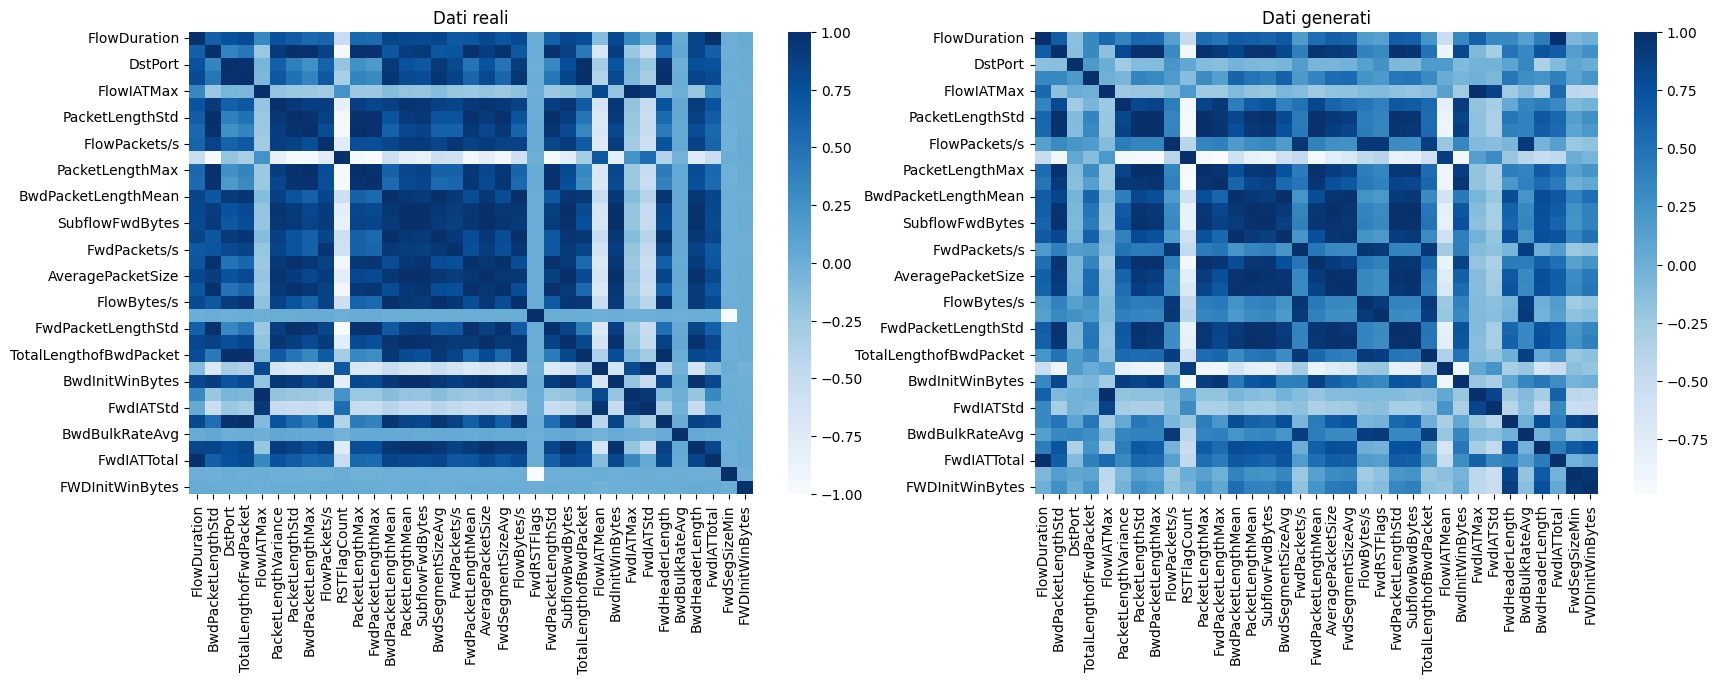

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.heatmap(df.corr(), annot=False, ax=ax[0], cmap="Blues")
sns.heatmap(gen_samples.corr(), annot=False, ax=ax[1], cmap="Blues")
ax[0].set_title("Dati reali")
ax[1].set_title("Dati generati")
plt.tight_layout()
plt.savefig(f"{images_dir}/VanillaGan_matrixCorrel_setHBase_Bruteforce_10000.pdf", dpi=200, format='pdf')

In [ ]:
real_data = df.to_numpy()
generated_data = gen_samples.to_numpy()

In [ ]:
from scipy.stats import wasserstein_distance

real_flat = real_data.flatten()
generated_flat = generated_data.flatten()
#provides a global measure of dissimilarity between the real and generated data distributions
w_distance = wasserstein_distance(real_flat, generated_flat)

print('Wasserstein Distance real vs gen:', w_distance)

Wasserstein Distance real vs gen: 0.0012166429798381978


In [ ]:
real_col = df['BwdPacketLengthStd'].to_numpy()
gen_col = gen_samples['BwdPacketLengthStd'].to_numpy()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(real_col, gen_col)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.0004575538251293456


* ***KLDivergence*** ==> you can use it to measure the difference between the distribution of your real data and the distribution of the generated data ==> =0



In [ ]:
kl = tf.keras.metrics.KLDivergence()
print("KLDivergence:", kl(real_col, gen_col).numpy())

KLDivergence: 95.70147


In [ ]:
w_dist_feature = wasserstein_distance(real_col, gen_col)
print("Wasserstein Distance:", w_dist_feature)

Wasserstein Distance: 0.0026490648566172277


In [ ]:
from scipy import stats
stats.ks_2samp(real_col, gen_col)

KstestResult(statistic=0.41048123980424145, pvalue=0.0, statistic_location=0.03184055909514427, statistic_sign=-1)

In [ ]:
# Choose the column you want to check
# 0 = FlowDuration
# 1 = BwdPacketLengthStd
# 2 = DstPort
# 3 = TotalLenghtofFwdPacket
# 4 = FlowIATMax
# 5 = PacketLengthVariance

# 12 = BwdPacketLengthMean

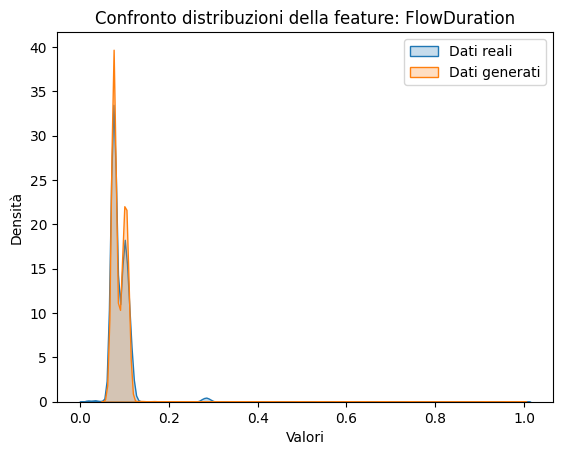

In [ ]:
column_to_compare = 0
# Extract the selected column for each array
real_column = real_data[:, column_to_compare]
generated_column = generated_data[:, column_to_compare]

# Plot the KDE for both distributions
sns.kdeplot(real_column, label='Dati reali', fill=True)
sns.kdeplot(generated_column, label='Dati generati', fill=True)

# Add labels and legend
plt.title(f'Confronto distribuzioni della feature: {df.columns[column_to_compare]}')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.legend(loc='best') #upper left
#salva in Drive
plt.savefig(f"{images_dir}/VanillaGan_confrontoDistribFeature-0_setHBase_Bruteforce_10000.pdf", dpi=200, format='pdf')
plt.show()

#### Scatter plot di feature in relazione & interessanti

In [ ]:
alphaTrasparenza = 0.2
#0 = trasparente & 1=pieno

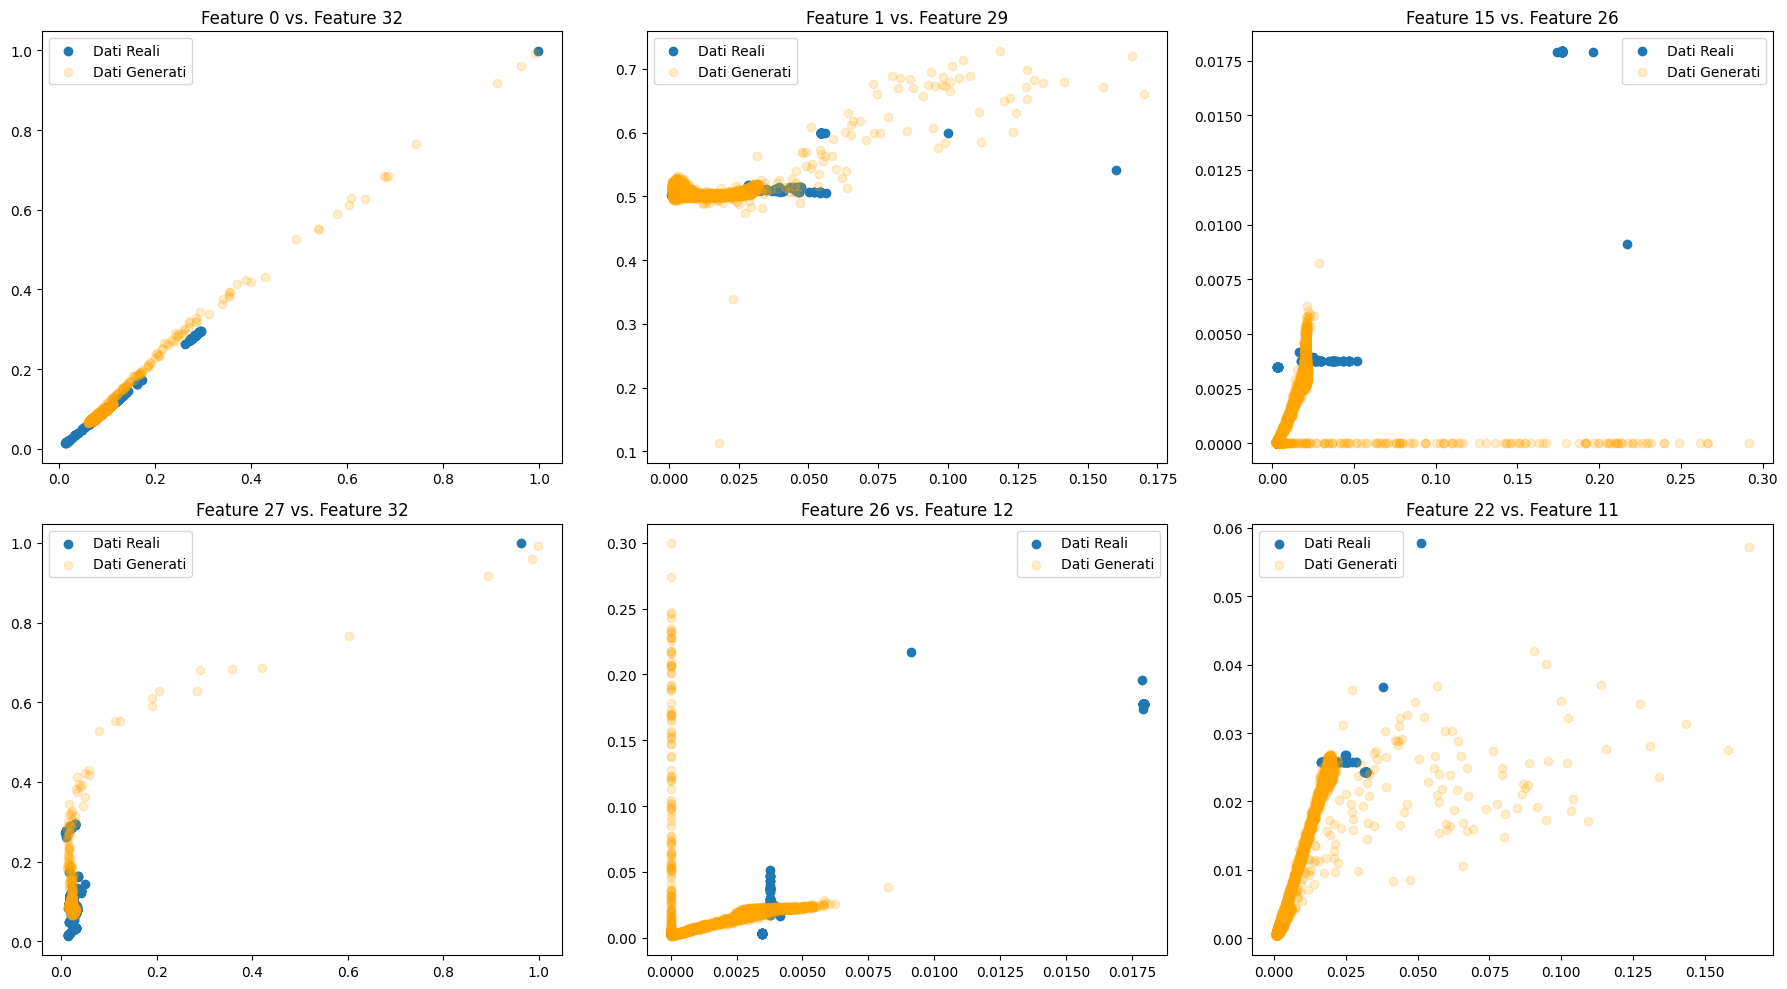

In [ ]:
alphaTrasparenza = 0.2
fig, axs = plt.subplots(2, 3, figsize=(18, 10))


axs[0, 0].scatter(df.iloc[:, 0], df.iloc[:, 32], label='Dati Reali')
axs[0, 0].scatter(gen_samples.iloc[:, 0], gen_samples.iloc[:, 32], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[0, 0].set_title("Feature 0 vs. Feature 32")
axs[0, 0].legend()


axs[0, 1].scatter(df.iloc[:, 1], df.iloc[:, 29], label='Dati Reali')
axs[0, 1].scatter(gen_samples.iloc[:, 1], gen_samples.iloc[:, 29], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[0, 1].set_title("Feature 1 vs. Feature 29")
axs[0, 1].legend()

axs[0, 2].scatter(df.iloc[:, 15], df.iloc[:, 26], label='Dati Reali')
axs[0, 2].scatter(gen_samples.iloc[:, 15], gen_samples.iloc[:, 26], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[0, 2].set_title("Feature 15 vs. Feature 26")
axs[0, 2].legend()

axs[1, 0].scatter(df.iloc[:, 27], df.iloc[:, 32], label='Dati Reali')
axs[1, 0].scatter(gen_samples.iloc[:, 27], gen_samples.iloc[:, 32], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[1, 0].set_title("Feature 27 vs. Feature 32")
axs[1, 0].legend()

axs[1, 1].scatter(df.iloc[:, 26], df.iloc[:, 12], label='Dati Reali')
axs[1, 1].scatter(gen_samples.iloc[:, 26], gen_samples.iloc[:, 12], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[1, 1].set_title("Feature 26 vs. Feature 12")
axs[1, 1].legend()

axs[1, 2].scatter(df.iloc[:, 22], df.iloc[:, 11], label='Dati Reali')
axs[1, 2].scatter(gen_samples.iloc[:, 22], gen_samples.iloc[:, 11], label='Dati Generati', c='orange', alpha=alphaTrasparenza)
axs[1, 2].set_title("Feature 22 vs. Feature 11")
axs[1, 2].legend()

plt.tight_layout()

plt.savefig(f"{images_dir}/VanillaGan_scatterPlot_setHBase_Bruteforce_10000.pdf", dpi=200, format='pdf')

plt.show()

#Valutazione SDV
*   https://github.com/sdv-dev/SDV
*   https://docs.sdv.dev/sdv



In [ ]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [ ]:
quality_report = evaluate_quality(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 595/595 [00:05<00:00, 108.92it/s]

Overall Score: 72.39%

Properties:
- Column Shapes: 57.64%
- Column Pair Trends: 87.13%


In [ ]:
diagnostic_report = run_diagnostic(
    real_data=df,
    synthetic_data=gen_samples,
    metadata=metadata)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 359.69it/s]

Overall Score: 94.79%

Properties:
- Data Validity: 89.59%
- Data Structure: 100.0%
